# A Quantum-Enhanced LSTM Layer

In [16]:
!pip install -r requirements.txt

  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached aiohttp-3.7.4.post0.tar.gz (1.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached appnope-0.1.2-py2.py3-none-any.whl (4.3 kB)
  Using cached argon2-cffi-21.1.0.tar.gz (1.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
  Using cached attrs-20.3.0-py2.py3-none-any.whl (49 kB)
  Using cached autograd-1.3.tar.gz (38 kB)
  Preparing metadata (setup.py) ... done
  Using cached beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Using cached bleach-4.1.0-py2.py3-none-any.whl (157 kB)
  Using cached bs4-0.0.1.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... done
  Using cached cachetools-4.2.1-py3-none-any.whl (12 kB)
  Using cached certifi-2020.12.5-py2.py3-none-any.whl

  Using cached parso-0.8.2-py2.py3-none-any.whl (94 kB)
  Using cached PennyLane-0.14.1.tar.gz (404 kB)
  Preparing metadata (setup.py) ... done
  Using cached PennyLane_qiskit-0.14.0-py3-none-any.whl (21 kB)
  Using cached Pillow-8.2.0-cp39-cp39-macosx_11_0_arm64.whl (2.7 MB)
  Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
  Using cached prometheus_client-0.11.0-py2.py3-none-any.whl (56 kB)
  Using cached prompt_toolkit-3.0.20-py3-none-any.whl (370 kB)
  Using cached protobuf-3.15.7-py2.py3-none-any.whl (173 kB)
  Using cached psutil-5.8.0.tar.gz (470 kB)
  Preparing metadata (setup.py) ... done
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pybind11-2.6.2-py2.py3-none-any.whl (191 kB)
  Using cached pycparser-2.20-py2.py3-none-any.whl (112 kB)
  Using cached Pygments-2.10.0-py3-none-any.whl (1.0 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached pyrsistent-0.17.3.tar.gz (106 kB)
  Preparing metadata (setup.py) ... don

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [18]:
import torch
import torch.nn as nn

import pennylane as qml


class QLSTM(nn.Module): #base LSTM structure for qubits
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        
    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)
            

Define the possible tags: determinant, noun, verb.

In [19]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Get index for every part of speech
ix_to_tag = {i:k for k,i in tag_to_ix.items()} #Reverse situation

The function below tokenizes the sentence and matches the label to each word.

In [20]:
def prepare_sequence(seq, to_ix): 
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long) #transform to tensors to work with in train func

Prepare the input dataset.

In [21]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Entities: {0: 'DET', 1: 'NN', 2: 'V'}


The idea is to pass the two sequences through the LSTM, which will output the hidden array of vectors [h_0, h_1, h_2, h_3, h_4], one for each word. A dense layer “head” is attached to the LSTM’s outputs to calculate the probability that each word may be a determinant, noun or verb.

In [22]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0: #see the kind of function
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        
    def forward(self, sentence): #going to the next word
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [44]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 300

In [45]:
model_classical = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

Following the example from the PyTorch website, we train the two networks (classical and quantum LSTM) for 300 epochs. 

In [46]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
            
            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history

In [47]:
history_classical = train(model_classical, n_epochs)

Epoch 1 / 300: Loss = 1.107 Acc = 0.44
Epoch 2 / 300: Loss = 1.103 Acc = 0.44
Epoch 3 / 300: Loss = 1.098 Acc = 0.44
Epoch 4 / 300: Loss = 1.094 Acc = 0.44
Epoch 5 / 300: Loss = 1.091 Acc = 0.44
Epoch 6 / 300: Loss = 1.087 Acc = 0.44
Epoch 7 / 300: Loss = 1.084 Acc = 0.44
Epoch 8 / 300: Loss = 1.081 Acc = 0.44
Epoch 9 / 300: Loss = 1.078 Acc = 0.44
Epoch 10 / 300: Loss = 1.075 Acc = 0.44
Epoch 11 / 300: Loss = 1.072 Acc = 0.44
Epoch 12 / 300: Loss = 1.070 Acc = 0.44
Epoch 13 / 300: Loss = 1.067 Acc = 0.44
Epoch 14 / 300: Loss = 1.065 Acc = 0.44
Epoch 15 / 300: Loss = 1.063 Acc = 0.44
Epoch 16 / 300: Loss = 1.060 Acc = 0.44
Epoch 17 / 300: Loss = 1.058 Acc = 0.44
Epoch 18 / 300: Loss = 1.056 Acc = 0.44
Epoch 19 / 300: Loss = 1.054 Acc = 0.44
Epoch 20 / 300: Loss = 1.052 Acc = 0.44
Epoch 21 / 300: Loss = 1.050 Acc = 0.44
Epoch 22 / 300: Loss = 1.047 Acc = 0.44
Epoch 23 / 300: Loss = 1.045 Acc = 0.44
Epoch 24 / 300: Loss = 1.043 Acc = 0.44
Epoch 25 / 300: Loss = 1.041 Acc = 0.44
Epoch 26 

Epoch 234 / 300: Loss = 0.073 Acc = 1.00
Epoch 235 / 300: Loss = 0.072 Acc = 1.00
Epoch 236 / 300: Loss = 0.071 Acc = 1.00
Epoch 237 / 300: Loss = 0.070 Acc = 1.00
Epoch 238 / 300: Loss = 0.070 Acc = 1.00
Epoch 239 / 300: Loss = 0.069 Acc = 1.00
Epoch 240 / 300: Loss = 0.068 Acc = 1.00
Epoch 241 / 300: Loss = 0.067 Acc = 1.00
Epoch 242 / 300: Loss = 0.066 Acc = 1.00
Epoch 243 / 300: Loss = 0.065 Acc = 1.00
Epoch 244 / 300: Loss = 0.065 Acc = 1.00
Epoch 245 / 300: Loss = 0.064 Acc = 1.00
Epoch 246 / 300: Loss = 0.063 Acc = 1.00
Epoch 247 / 300: Loss = 0.062 Acc = 1.00
Epoch 248 / 300: Loss = 0.062 Acc = 1.00
Epoch 249 / 300: Loss = 0.061 Acc = 1.00
Epoch 250 / 300: Loss = 0.060 Acc = 1.00
Epoch 251 / 300: Loss = 0.060 Acc = 1.00
Epoch 252 / 300: Loss = 0.059 Acc = 1.00
Epoch 253 / 300: Loss = 0.058 Acc = 1.00
Epoch 254 / 300: Loss = 0.058 Acc = 1.00
Epoch 255 / 300: Loss = 0.057 Acc = 1.00
Epoch 256 / 300: Loss = 0.056 Acc = 1.00
Epoch 257 / 300: Loss = 0.056 Acc = 1.00
Epoch 258 / 300:

In [48]:
def print_result(model):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [49]:
print_result(model_classical)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


In [50]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [51]:
history_quantum = train(model_quantum, n_epochs)

Epoch 1 / 300: Loss = 1.105 Acc = 0.44
Epoch 2 / 300: Loss = 1.099 Acc = 0.44
Epoch 3 / 300: Loss = 1.093 Acc = 0.44
Epoch 4 / 300: Loss = 1.088 Acc = 0.44
Epoch 5 / 300: Loss = 1.084 Acc = 0.44
Epoch 6 / 300: Loss = 1.080 Acc = 0.44
Epoch 7 / 300: Loss = 1.076 Acc = 0.44
Epoch 8 / 300: Loss = 1.073 Acc = 0.44
Epoch 9 / 300: Loss = 1.070 Acc = 0.44
Epoch 10 / 300: Loss = 1.067 Acc = 0.44
Epoch 11 / 300: Loss = 1.064 Acc = 0.44
Epoch 12 / 300: Loss = 1.061 Acc = 0.44
Epoch 13 / 300: Loss = 1.058 Acc = 0.44
Epoch 14 / 300: Loss = 1.056 Acc = 0.44
Epoch 15 / 300: Loss = 1.053 Acc = 0.44
Epoch 16 / 300: Loss = 1.050 Acc = 0.44
Epoch 17 / 300: Loss = 1.048 Acc = 0.44
Epoch 18 / 300: Loss = 1.045 Acc = 0.44
Epoch 19 / 300: Loss = 1.042 Acc = 0.44
Epoch 20 / 300: Loss = 1.039 Acc = 0.44
Epoch 21 / 300: Loss = 1.037 Acc = 0.44
Epoch 22 / 300: Loss = 1.033 Acc = 0.44
Epoch 23 / 300: Loss = 1.030 Acc = 0.44
Epoch 24 / 300: Loss = 1.027 Acc = 0.44
Epoch 25 / 300: Loss = 1.024 Acc = 0.44
Epoch 26 

Epoch 204 / 300: Loss = 0.223 Acc = 1.00
Epoch 205 / 300: Loss = 0.221 Acc = 1.00
Epoch 206 / 300: Loss = 0.219 Acc = 1.00
Epoch 207 / 300: Loss = 0.217 Acc = 1.00
Epoch 208 / 300: Loss = 0.215 Acc = 1.00
Epoch 209 / 300: Loss = 0.213 Acc = 1.00
Epoch 210 / 300: Loss = 0.211 Acc = 1.00
Epoch 211 / 300: Loss = 0.209 Acc = 1.00
Epoch 212 / 300: Loss = 0.207 Acc = 1.00
Epoch 213 / 300: Loss = 0.205 Acc = 1.00
Epoch 214 / 300: Loss = 0.203 Acc = 1.00
Epoch 215 / 300: Loss = 0.201 Acc = 1.00
Epoch 216 / 300: Loss = 0.200 Acc = 1.00
Epoch 217 / 300: Loss = 0.198 Acc = 1.00
Epoch 218 / 300: Loss = 0.196 Acc = 1.00
Epoch 219 / 300: Loss = 0.194 Acc = 1.00
Epoch 220 / 300: Loss = 0.192 Acc = 1.00
Epoch 221 / 300: Loss = 0.191 Acc = 1.00
Epoch 222 / 300: Loss = 0.189 Acc = 1.00
Epoch 223 / 300: Loss = 0.187 Acc = 1.00
Epoch 224 / 300: Loss = 0.185 Acc = 1.00
Epoch 225 / 300: Loss = 0.184 Acc = 1.00
Epoch 226 / 300: Loss = 0.182 Acc = 1.00
Epoch 227 / 300: Loss = 0.180 Acc = 1.00
Epoch 228 / 300:

In [52]:
print_result(model_quantum)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


### Plot the training history

In [53]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM loss", color='orange', linestyle='dashed')
    ax1.plot(loss_q, label="Quantum LSTM loss", color='red', linestyle='solid')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM accuracy", color='steelblue', linestyle='dashed')
    ax2.plot(acc_q, label="Quantum LSTM accuracy", color='blue', linestyle='solid')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.1)
    #plt.legend(loc="upper right")
    fig.legend(loc="upper right", bbox_to_anchor=(1,0.8), bbox_transform=ax1.transAxes)

    plt.savefig("pos_training.pdf")
    plt.savefig("pos_training.png")
    plt.show()

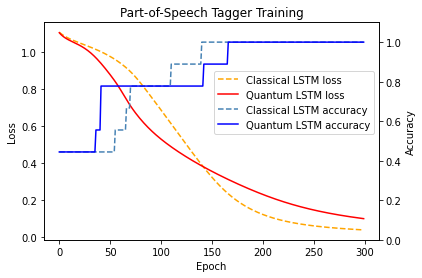

In [54]:
plot_history(history_classical, history_quantum) #comparison of two models

The loss function decreases as a function of the training epoch, and after 300 epochs both networks are able to tag correctly the first sentence.